# Train language model

In [1]:
import io

import numpy as np

from scipy.ndimage import gaussian_filter1d

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm

## Data loader

In [2]:
# Choose whether to use GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
# Character set
CHARACTERS = ["<PAD>"] + list(" !'\"(),-.:;?abcdefghijklmnopqrstuvwxyzàâäçèéêëîïôöùûü")
CHARACTER_MAP = {c: i for i, c in enumerate(CHARACTERS)}

In [4]:
# Convert string to tensor
def to_indices(text):
    tensor = torch.zeros(len(text) + 2, dtype=torch.long)
    for i, c in enumerate(text):
        tensor[i + 1] = CHARACTER_MAP[c]
    return tensor

In [5]:
# Define infinite text iterator
class TextDataset(torch.utils.data.IterableDataset):
    def __init__(self, path):
        super().__init__()
        self.path = path

    def __iter__(self):
        
        # Open file for streaming
        file = io.open(self.path, "rb")
        
        try:
        
            # Compute size
            size = file.seek(0, io.SEEK_END)

            # Each worker has access to the whole dataset, but each of them starts at a different location
            worker_info = torch.utils.data.get_worker_info()
            if worker_info is None:
                offset = 0
            else:
                print(worker_info.id, worker_info.num_workers)
                offset = (size * worker_info.id) // worker_info.num_workers
            file.seek(offset, io.SEEK_SET)

            # To ensure that we are not inside a word (or even a multi-byte character), search next new line
            if offset > 0:
                while file.read(1) != b"\n":
                    pass

            # Wrap as text file
            file = io.TextIOWrapper(file, encoding="utf-8", newline="\n")

            # Iterate over line
            while True:
                for line in file:
                    line = line[:-1]
                    tensor = to_indices(line)
                    yield tensor
                
                # When file is exhausted, just re-open it from the beginning
                file.seek(0, io.SEEK_SET)
        
        finally:
            file.close()

In [6]:
# Load news dataset
dataset = TextDataset("./news.txt")

In [7]:
# Need special collate function to handle variable-length data
def collate(batch):
    sequences = nn.utils.rnn.pad_sequence(batch)
    lengths = torch.tensor([len(i) for i in batch], dtype=torch.long)
    return sequences, lengths

In [8]:
# Create loader
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate,
    pin_memory=use_cuda,
)

## Define model

In [9]:
# Compute sequence loss, properly ignoring padding
def masked_cross_entropy(logits, target, mask):
    
    # Flatten tensors
    num_classes = logits.shape[-1]
    logits = logits.reshape(-1, num_classes)
    target = target.reshape(-1)
    mask = mask.reshape(-1)
    
    # Compute masked categorical loss
    mask = mask.to(torch.float)
    losses = F.cross_entropy(logits, target, reduction="none") * mask
    loss = losses.sum() / mask.sum()
    return loss

In [10]:
class Model(nn.Module):
    def __init__(self, num_symbols, embedding_size, hidden_size):
        super().__init__()
        
        # Store parameters
        self.num_symbols = num_symbols
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        # Symbols are embedded
        self.embedding = nn.Embedding(
            num_embeddings=num_symbols,
            embedding_dim=embedding_size,
            padding_idx=0,
        )
        
        # Using bidirectional GRU, each direction being one language model
        self.rnn = nn.GRU(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
        )
        
        # Use simple classification layer, for both direction
        self.forward_classifier = nn.Linear(hidden_size, num_symbols)
        self.backward_classifier = nn.Linear(hidden_size, num_symbols)
    
    def encode(self, sequences, lengths):
        
        # First, embed symbols
        embedded_sequences = self.embedding(sequences)
        
        # For efficiency (i.e. avoid encoding padding), use packed sequence object
        packed_embedded_sequences = nn.utils.rnn.pack_padded_sequence(
            input=embedded_sequences,
            lengths=lengths,
            enforce_sorted=False,
        )
        
        # Apply RNN, discard state
        packed_encoded_sequences, _ = self.rnn(packed_embedded_sequences)
        
        # Unpack sequences to original lengths
        encoded_sequences, _ = nn.utils.rnn.pad_packed_sequence(
            sequence=packed_encoded_sequences,
            total_length=sequences.shape[0],
        )
        
        return encoded_sequences
    
    def infer(self, sequences, lengths):
        
        # Apply bi-directional encoder
        encoded_sequences = self.encode(sequences, lengths)
        
        # Apply classifiers
        forward_logits = self.forward_classifier(encoded_sequences[:, :, :self.hidden_size])
        backward_logits = self.backward_classifier(encoded_sequences[:, :, self.hidden_size:])
        
        return forward_logits, backward_logits
    
    def forward(self, sequences, lengths):
        
        # Apply model
        forward_logits, backward_logits = self.infer(sequences, lengths)
        
        # Compute loss
        max_output_length = sequences.shape[0]
        mask = torch.arange(max_output_length, device=lengths.device)[:, None] < lengths[None, :]
        forward_loss = masked_cross_entropy(forward_logits[:-1], sequences[1:], mask[1:])
        backward_loss = masked_cross_entropy(backward_logits[1:], sequences[:-1], mask[1:])
        return forward_loss + backward_loss

## Do training

In [11]:
# Instanciate model
model = Model(
    num_symbols=len(CHARACTERS),
    embedding_size=32,
    hidden_size=128,
)
if use_cuda:
    model.cuda()

# Instanciate optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [12]:
# Train loop
iterator = iter(loader)
num_steps = 1000
num_epochs = 50
losses = []
for epoch in range(num_epochs):
    for step in tqdm(range(num_steps)):
        
        # Get batch
        sequences, lengths = next(iterator)
        if use_cuda:
            sequences = sequences.cuda()
            lengths = lengths.cuda()
        
        # Apply model
        loss = model(sequences, lengths)
        loss_value = loss.item()
        assert not np.isnan(loss_value)
        losses.append(loss_value)
        
        # Back-propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 15.13it/s]


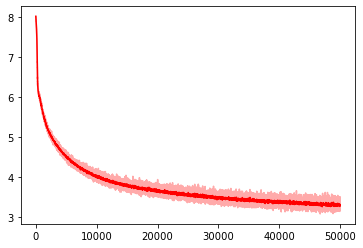

In [13]:
# Plot training loss
fig, ax = plt.subplots()

y = np.array(losses)
x = np.arange(y.shape[0])
y_smooth = gaussian_filter1d(y, 5, mode="nearest")

ax.plot(x, y, c="#ffaaaa")
ax.plot(x, y_smooth, "r")

plt.show()

In [14]:
# Save trained model for later
model.cpu()
torch.save(model.state_dict(), "lm.pt")

In [15]:
# Get ready for inference
model.eval()

Model(
  (embedding): Embedding(54, 32, padding_idx=0)
  (rnn): GRU(32, 128, bidirectional=True)
  (forward_classifier): Linear(in_features=128, out_features=54, bias=True)
  (backward_classifier): Linear(in_features=128, out_features=54, bias=True)
)

## Generate text

In [16]:
def choose(probabilities):
    if isinstance(probabilities, torch.Tensor):
        probabilities = probabilities.numpy()
    p = np.random.rand()
    cs = probabilities.cumsum()
    return np.searchsorted(cs, p)

def forward():
    
    # For convenience, use a GRU cell object, with equivalent parameters
    gru = model.rnn
    forward_cell = torch.nn.GRUCell(gru.input_size, gru.hidden_size)
    forward_cell.bias_ih = gru.bias_ih_l0
    forward_cell.bias_hh = gru.bias_hh_l0
    forward_cell.weight_ih = gru.weight_ih_l0
    forward_cell.weight_hh = gru.weight_hh_l0
    
    # Start with zero state
    h = torch.zeros((1, gru.hidden_size))
    
    # Loop forever, starting with <PAD> symbol
    i = 0
    while True:
        
        # Apply model
        with torch.no_grad():
            x = model.embedding(torch.tensor([i]))
            h = forward_cell(x, h)
            logits = model.forward_classifier(h).squeeze(0)
            probabilities = torch.softmax(logits, dim=-1)
            # TODO sample based on probabilities
            #i = probabilities.argmax()
            #yield probabilities
            i = choose(probabilities)
        yield CHARACTERS[i]

def sample(n=32):
    it = forward()
    return "".join(next(it) for _ in range(n))

In [17]:
for _ in range(10):
    print(sample())

presse", juste un cindénait inde
le céble, just se dandique, abus
le périeurs y évolus des totra m
glus", est un trapident maradi à
tout laëant fonc qu'en comme com
mous poursante, ce ma reprete jo
l"évra op se croitér de l'europé
un années du cinqud du bruige av
le clayeux moins que caphen cou"
le bleu-mogenne éth sur d'attriq


## Assess likelihood of given text

In [18]:
def likelihood(text):
    
    # Convert to indices, remove trailing <PAD> symbol
    sequence = to_indices(text)[:-1]
    
    # Apply forward model
    sequences = sequence.unsqueeze(1)
    lengths = torch.tensor(sequences.shape[0]).unsqueeze(0)
    forward_logits, _ = model.infer(sequences, lengths)
    forward_logits = forward_logits.squeeze(1)
    forward_log_probabilities = torch.log_softmax(forward_logits, dim=-1)
    
    # Collect all transitions
    # Note that initial probability of having <PAD> is 100%
    transition_log_probabilities = torch.zeros(sequence.shape[0] - 1)
    for i in range(sequence.shape[0] - 1):
        transition_log_probabilities[i] = forward_log_probabilities[i, sequence[i + 1]]
    
    # Compute average probability per symbol, which we use as "score"
    # Since p(x) = p(x_0) * p(x_1|x_0) * p(x_2|x_0,x_1) * ...
    # And if we assume that x_i are independent, such as p(x) = p(x_0) * p(x_1) * ...
    # Then the probability of the "average" symbol is p(x~) = (prod_i p(x_i)) ** (1/n)
    average_log_probability = transition_log_probabilities.mean()
    average_probability = torch.exp(average_log_probability).item()
    return average_probability

In [19]:
likelihood("bonjour !")

0.052350472658872604

In [20]:
likelihood("jsgfhsjdfg")

0.0004421671328600496

In [21]:
likelihood("depuis la dernière fois")

0.3153892159461975

In [22]:
likelihood("aaaaaaaaaaa")

0.0002812459715642035